In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
from pdb import set_trace

Add country names to country adjacency matrix:

In [4]:
country_names = pd.read_csv('../Data/RefugeeCountries.csv', header=None, names=['Country'])
country_adjacency = pd.read_csv('../Data/CountryAdjacencyNew.csv', header=None, names=country_names.Country)
country_adjacency.set_index(country_names.Country, inplace=True)
country_adjacency.head()

country_adjacency_without_names = pd.read_csv('../Data/CountryAdjacencyNew.csv', header=None)

In [5]:
country_adjacency.shape

(214, 214)

In [6]:
country_adjacency.Netherlands.sort_values(ascending=False).head(10)

Country
Netherlands     1.000000
Suriname        0.799704
Aruba           0.799063
Namibia         0.781950
Botswana        0.775188
Anguilla        0.775163
Dominica        0.775163
Nauru           0.775163
Sierra Leone    0.775163
Liberia         0.775163
Name: Netherlands, dtype: float64

In [7]:
def CalculateMetrics(G,Type,adjecencyMatrix):
    print(nx.info(G))
    weight =nx.is_weighted(G)
    print(weight)
    print('Link Density: '+str(nx.density(G)))

    num_nodes = G.number_of_nodes()
    print('Number of nodes: '+str(num_nodes))
    num_links = G.number_of_edges()
    print('Number of edges: '+str(num_links))

    all_links = G.edges()

    #print(all_links)

    degrees = [0]*(num_nodes + 1)

    if Type =="Language":
        for i in range(0,len(adjecencyMatrix)):
            for j in range(0,len(adjecencyMatrix)):
                if (i!=j):
                    degrees[i] += adjecencyMatrix[i][j]
    if Type=="Refugee":
       for i in range(0,len(adjecencyMatrix)):
            for j in range(0,len(adjecencyMatrix)):
                if (i!=j):
                    if adjecencyMatrix[i][j]!= 0:
                        degrees[i] += 1
    #set_trace()
    degrees = degrees[1:]

    print('average degrees: ', np.mean(degrees))
    print('standard dev degrees: ', np.std(degrees))


    round_degrees = [int(x) for x in np.round(degrees)]
    degree_x = np.arange(1,max(round_degrees)+1)
    degree_y = [0]*(max(round_degrees))
    for i in range(max(round_degrees)):
      degree_y[i] = round_degrees.count(i+1)/num_nodes
    fig, ax = plt.subplots()
    ax.plot(degree_x, degree_y)
    ax.set(xlabel='degree k', ylabel='P[D=k]',
           title='Degree distribution for Language Data')
    ax.grid()
    plt.show()


    print("Clustering Coefficient: "+str(nx.average_clustering(G)))
    if Type!="Refugee":
        print("Average Hopcount: "+ str(nx.average_shortest_path_length(G)))
    
    #print("Betweenness: "+ str(nx.betweenness_centrality(G)))
    print("degree_cor: " + str(nx.degree_pearson_correlation_coefficient(G))) #means that i disassortative

    #print("Average Node Connectivity:"+str(nx.average_node_connectivity(G))) #very high since everythong is connected
    print("Edge Connectivity:"+str(nx.edge_connectivity(G)))

Create graph of language similarity between countries:

214
Name: Language similarity between countries
Type: Graph
Number of nodes: 214
Number of edges: 23002
Average degree: 214.9720
True
Link Density: 1.0092580404545655
Number of nodes: 214
Number of edges: 23002
average degrees:  84.33605416300844
standard dev degrees:  29.346122586586254


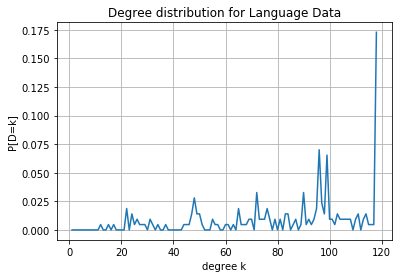

Clustering Coefficient: 0.9998687673045364
Average Hopcount: 1.000131630906937
degree_cor: -0.00574213751382539
Edge Connectivity:212


In [10]:
G = nx.from_pandas_adjacency(country_adjacency.T)
G.name = 'Language similarity between countries'
#can not partition to more than one clique for our graph
c=list(community.k_clique_communities(G,2))
print(len(c[0]))

CalculateMetrics(G,"Language",country_adjacency_without_names)

c:\users\thoru\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


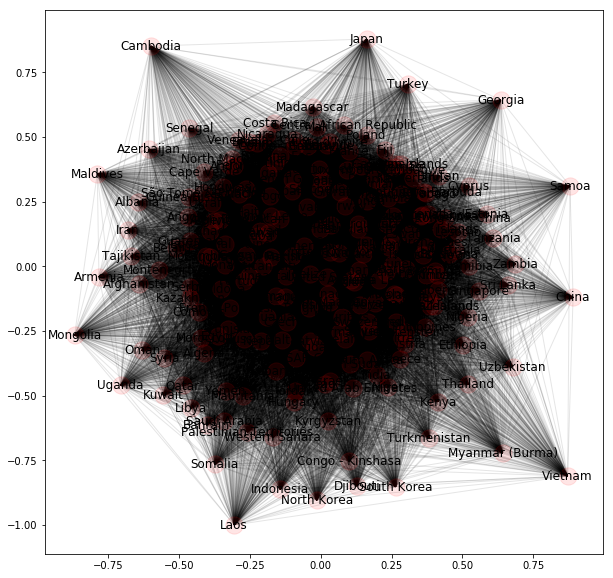

In [11]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()

Read one year of refugee data, rows denote country of asylum, columns denote country of origin.

In [13]:
refugee_data_folder = '../Data/RefugeeMatrices/'
years =range(2007,2017)
yearInfo = dict()
for i in years:
    yearMatrix_no_name = pd.read_csv(refugee_data_folder + 'RefugeeAdjacency'+str(i)+'.csv', header=None,dtype=int)   
    
    yearMatrix = pd.read_csv(refugee_data_folder + 'RefugeeAdjacency'+str(i)+'.csv', header=None, names=country_names.Country, dtype=int)
    yearMatrix.set_index(country_names.Country, inplace=True)
    yearMatrix.head()
    
    #Convert refugee adjacency matrix to percentage refugees of origin country:
    normalizedMatrix = yearMatrix.div(yearMatrix.sum(axis=0), axis=1)
    normalizedMatrix.fillna(0, inplace=True)
    
    #only include values that are above this threshold
    threshold = 0.85
    refugee_masked = yearMatrix.mask(normalizedMatrix < threshold, 0)
    
    #Create directed graph with networkx from adjacency df. Transpose df because networkx uses rows as source nodes and columns as target nodes. Remove nodes that have less refugees than certain threshold and create two graphs of language similarity and refugees.
    Graph = nx.from_pandas_adjacency(refugee_masked.T, create_using=nx.DiGraph())
    Graph.name = 'Refugee '+ str(i)
    Graph_no_index = nx.from_pandas_adjacency(yearMatrix.T, create_using=nx.DiGraph())
    Graph_no_index.name = 'Refugee '+ str(i)
    
    entry={'year':str(i),'matrix_without_names':yearMatrix_no_name,'matrix_with_names':yearMatrix,'normalized_with_names':normalizedMatrix,'graph':Graph ,'graph_no_index':Graph_no_index , 'countRefugees': 0,'Origin_Countpercountry':{},'Asylum_Countpercountry':{}}
   
    yearInfo[str(i)]=entry
    
for year in years:
    matrix = yearInfo[str(year)]['matrix_without_names']
    names = country_names.Country
    countAll =0
    for i in range(0,len(matrix)):
            Origin_count=0
            Asylum_count=0
            for j in range(0,len(matrix)):
                Origin_count+=matrix[i][j]
                Asylum_count +=matrix[j][i]
                countAll += matrix[i][j]
            yearInfo[str(year)]['Origin_Countpercountry'][names[i]]=Origin_count
            yearInfo[str(year)]['Asylum_Countpercountry'][names[i]]=Asylum_count
    yearInfo[str(year)]['countRefugees'] =countAll

In [14]:
#print(sorted(yearInfo['1975']['Asylum_Countpercountry'].items(), key=lambda item: item[1],reverse=True)

print(yearInfo['2016']['matrix_without_names'])

       0     1    2    3     4    5    6    7     8    9    ...  204  205  \
0        0     0    0    0     0    0    0    0     0    0  ...    0    0   
1        0     0    0    0     0    0    0    0     0    0  ...    0    0   
2        2     0    0    0     0    0    0    0     0    0  ...    0    0   
3        0     0    0    0     0    0    0    0     0    0  ...    0    0   
4        0     0    1    0     0    0    0    0     0    0  ...    0    0   
5        0     0    0    0     0    0    0    0     0    0  ...    0    0   
6        0     0    0    0     0    0    0    0     0    0  ...    0    0   
7        5    18   31    0    14    0    0    0    79    0  ...    4    0   
8        0     0    0    0     0    0    0    0     0    0  ...    0    0   
9        0     0    0    0     0    0    0    0     0    0  ...    0    0   
10    9217    58   10    0     1    0    0    1     1    0  ...   20    0   
11   20220    93   53    0   105    0    0    0   856    0  ...    3    0   

In [15]:
#Clean one matrix to use again
CleanMatrix= yearInfo['2016']['matrix_with_names']
for indexRow, country_name_row in country_names.iterrows():   
    for indexColumn, country_name_colums in country_names.iterrows():
        CleanMatrix[country_name_row['Country']][country_name_colums['Country']]= 0

In [ ]:
for year in yearInfo:
    languageDataMatrix= CleanMatrix
    
    for indexRow, country_name_row in country_names.iterrows(): 
        
        for indexColumn, country_name_colums in country_names.iterrows():
            language_value = country_adjacency[(country_name_row['Country'])][(country_name_colums['Country'])]
            refugee_value =yearInfo[year]['normalized_with_names'][(country_name_row['Country'])][(country_name_colums['Country'])]
            connection_value =refugee_value-language_value  
            connection =max(0, connection_value)
            #print('connection: '+str(connection))
            languageDataMatrix[(country_name_row['Country'])][(country_name_colums['Country'])]=connection
            
    yearInfo[year]['relation_to_languageData'] = languageDataMatrix

In [ ]:
#set year we want to look at.
year = '2010'
test = nx.from_pandas_adjacency(yearInfo[year]['relation_to_languageData'], create_using=nx.DiGraph())

refugee_year_no_name=yearInfo[year]['matrix_without_names']
#print(refugee_2016)

refugee_year=yearInfo[year]['matrix_with_names']
#print(refugee_2016['Afghanistan'])

 
refugee_year = refugee_year.div(refugee_year.sum(axis=0), axis=1)
#print(refugee_2016['Afghanistan'])
refugee_year.fillna(0, inplace=True)
refugee_year.head()


In [ ]:
communities = nx.community.asyn_lpa_communities(yearInfo[year]['graph'])
for community in communities:
    print(community)

CalculateMetrics(yearInfo[year]['graph_no_index'],"Refugee",yearInfo[year]['matrix_without_names'])

In [ ]:
nodes_to_remove = list(nx.isolates(yearInfo[year]['graph']))
yearInfo[year]['graph'].remove_nodes_from(nodes_to_remove)
print(nx.info(yearInfo[year]['graph']))

In [ ]:
G.remove_nodes_from(nodes_to_remove)
print(nx.info(G))

In [ ]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(yearInfo[year]['graph'])
nx.draw_networkx_nodes(yearInfo[year]['graph'], pos, alpha=0.1)
nx.draw_networkx_labels(yearInfo[year]['graph'], pos)
nx.draw_networkx_edges(yearInfo[year]['graph'], pos)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha=0.1)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()